# GNN Models for extractive summarization

In [ ]:
import json
from pathlib import Path
import pandas as pd
import os
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric
import torch_geometric.nn as gnn
from torch_geometric.data import DataLoader
from torch.utils.data import Dataset

import torch.optim as optim

In [ ]:
from sentence_transformers import SentenceTransformer
bert = SentenceTransformer('all-MiniLM-L6-v2')

## Utils functions

In [3]:
def load_dataset(data_split):
  """
  Function to load the dataset from the JSON files
  :param data_split: Path to the folder containing the JSON files
  :param test: Boolean to indicate whether the dataset is the test set
  :return: List of graphs and list of graph names
  """
  graphs = []      # Actual graph objects
  graph_names = [] # Names of all dialogues

  # Load graph names
  for file_path in os.listdir(data_split):
    if file_path.endswith('.json'):
      graph_names.append(file_path[:-5])

  ####################################################################
  # Load labels (1/0 for extractive summary)
  ####################################################################
  with open(data_split + '_labels.json') as training_labels_file:
    data_labels = json.load(training_labels_file)

  # Encode roles for each dialogue
  speakers = {"PM": [1, 0, 0, 0], "ME": [0, 1, 0, 0], "UI": [0, 0, 1, 0], "ID": [0, 0, 0, 1]}

  attributes = {
    'Continuation': np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
    'Explanation': np.array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
    'Elaboration': np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
    'Acknowledgement': np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
    'Comment': np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
    'Result': np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
    'Question-answer_pair': np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
    'Contrast': np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]),
    'Clarification_question': np.array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
    'Background': np.array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    'Narration': np.array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    'Alternation': np.array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    'Conditional': np.array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    'Q-Elab': np.array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    'Correction': np.array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    'Parallel': np.array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
  }

  for graph_name in graph_names:

    labels = []
    edge_index = [[], []]
    edge_attribute = []

    ####################################################################
    # Load graph edges i.e connections between occurrences
    ####################################################################
    graph_edges = []
    with open(data_split + '/' + graph_name + '.txt', 'r') as file:
      for line in file.readlines():
        split = line[:-1].split(' ')
        index1 = int(split[0])
        index2 = int(split[2])
        edge = {"index1": index1, "index2": index2, "name": split[1]}
        graph_edges.append(edge)

    ############################################################
    # Load occurrences from dialogue from JSON file
    ############################################################
    with open(data_split + '/' + graph_name + '.json') as file:
      print('Processing JSON data of ' + graph_name + '...')
      graph_json = json.load(file)

      X = np.zeros((len(graph_json), n_embed))

      # Calculate embeddings
      occurrences = [node["text"] for node in graph_json]
      occurrence_embeddings = bert.encode(occurrences, show_progress_bar=True)

      count = 0
      for node in graph_json:
        idx = node["index"]

        if not (idx == count):
          raise Exception("aaa")
        count += 1

        spk = speakers[node["speaker"]]
        lbl = data_labels[graph_name][idx]

        X[idx][:4] = np.array(spk)
        X[idx][4:] = np.array(occurrence_embeddings[idx])
        labels.append(lbl)

      for edge in graph_edges:
        edge_index[0].append(edge['index1'])
        edge_index[1].append(edge['index2'])
        edge_attribute.append(attributes[edge['name']])

    graph = torch_geometric.data.Data(x=torch.FloatTensor(X), edge_index=torch.LongTensor(edge_index),
                      edge_attr=torch.LongTensor(edge_attribute), y=torch.LongTensor(labels))
    graphs.append(graph)
  return graphs

In [ ]:
graphs = load_dataset('data/train')

### TEST UTILS FUNCTIONS

## Test PyTorch Geometric

In [4]:
class GNN(torch.nn.Module):
  def __init__(self, n_features, n_classes, n_hidden, dropout):
    super(GNN, self).__init__()
    
    # Define the graph convolutional layers
    self.conv1 = gnn.GeneralConv(n_features, n_hidden[0])
    self.conv2 = gnn.GeneralConv(n_hidden[0], n_hidden[1])
    # self.conv3 = gnn.GATConv(n_hidden_1, n_hidden_2)

    # Define the linear layers
    self.linear1 = nn.Linear(n_hidden[1], n_hidden[2])
    self.linear2 = nn.Linear(n_hidden[2], n_classes)

    # Define the dropout layer
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, edge_index):
    # Perform graph convolution and activation function
    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = self.dropout(x)

    x = self.conv2(x, edge_index)
    x = F.relu(x)

    # Perform linear transformation and activation function
    x = self.linear1(x)
    x = F.relu(x)
    x = self.linear2(x)

    # Apply log softmax activation function
    return F.log_softmax(x, dim=1)

In [5]:
def train(model, optimizer, criterion, scheduler, train_loader, val_loader, n_epochs, device="cpu"):
  """
  Function to train the model.

  Args:
  - model: The GNN model to be trained
  - optimizer: The optimizer used for training
  - criterion: The loss function
  - scheduler: The learning rate scheduler
  - train_loader: The data loader for the training set
  - val_loader: The data loader for the validation set
  - n_epochs: The number of epochs to train for
  - device: The device to run the training on (default: "cpu")

  Returns:
  - train_loss: List of training losses for each epoch
  - val_loss: List of validation losses for each epoch
  - train_acc: List of training accuracies for each epoch
  - val_acc: List of validation accuracies for each epoch
  - train_f1: List of training F1 scores for each epoch
  - val_f1: List of validation F1 scores for each epoch
  """

  # Metrics for each epoch
  train_loss = []
  val_loss = []
  train_acc = []
  val_acc = []
  train_f1 = []
  val_f1 = []

  for epoch in range(n_epochs):
    train_loss_sublist = []
    train_acc_sublist = []
    train_f1_sublist = []

    # Training loop
    for data in train_loader:
      model.train()
      optimizer.zero_grad()
      output = model(data.x.to(device), data.edge_index.to(device))
      loss = criterion(output, data.y.to(device))
      loss.backward()
      optimizer.step()

      train_loss_sublist.append(loss.item())
      train_acc_sublist.append(accuracy_score(data.y.cpu(), output.cpu().argmax(dim=1)))
      train_f1_sublist.append(f1_score(data.y.cpu(), output.cpu().argmax(dim=1)))

    train_loss.append(np.mean(train_loss_sublist))
    train_acc.append(np.mean(train_acc_sublist))
    train_f1.append(np.mean(train_f1_sublist))

    val_loss_sublist = []
    val_acc_sublist = []
    val_f1_sublist = []

    # Validation loop
    for data in val_loader:
      model.eval()
      with torch.no_grad():
        output = model(data.x.to(device), data.edge_index.to(device))
        loss = criterion(output, data.y.to(device))

        val_loss_sublist.append(loss.item())
        val_acc_sublist.append(accuracy_score(data.y.cpu(), output.cpu().argmax(dim=1)))
        val_f1_sublist.append(f1_score(data.y.cpu(), output.cpu().argmax(dim=1)))

    val_loss.append(np.mean(val_loss_sublist))
    val_acc.append(np.mean(val_acc_sublist))
    val_f1.append(np.mean(val_f1_sublist))

    # Check if scheduler is not None
    if scheduler is not None:
      scheduler.step(val_loss[-1])

    print(f"Epoch {epoch} : train loss {train_loss[-1]}, val loss {val_loss[-1]}, train acc {train_acc[-1]}, val acc {val_acc[-1]}, train f1 {train_f1[-1]}, val f1 {val_f1[-1]}")

    if epoch > 10:
      torch.save(model.state_dict(), 'final_model/model' + str(epoch) + '.pt')

  return train_loss, val_loss, train_acc, val_acc, train_f1, val_f1

In [6]:
class ResGatedGraph(torch.nn.Module):
  def __init__(self, n_features, n_classes, n_hidden, dropout):
    super(ResGatedGraph, self).__init__()
    self.conv1 = gnn.ResGatedGraphConv(n_features, n_hidden[0])
    self.conv2 = gnn.ResGatedGraphConv(n_hidden[0], n_hidden[1])
    # self.conv3 = gnn.GATConv(n_hidden_1, n_hidden_2)

    self.linear1 = nn.Linear(n_hidden[1], n_hidden[2])
    self.linear2 = nn.Linear(n_hidden[2], n_classes)

    self.dropout = nn.Dropout(dropout)

  def forward(self, x, edge_index):
    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = self.dropout(x)

    x = self.conv2(x, edge_index)
    x = F.relu(x)

    # x = self.conv2(x, edge_index)
    # x = F.relu(x)
    # x = self.dropout(x)

    # x = self.conv3(x, edge_index)
    # x = F.relu(x)

    x = self.linear1(x)
    x = F.relu(x)
    x = self.linear2(x)

    return F.log_softmax(x, dim=1)

In [7]:
class Transformer(torch.nn.Module):
  def __init__(self, n_features, n_classes, n_hidden, dropout):
    super(Transformer, self).__init__()
    self.conv1 = gnn.TransformerConv(n_features, n_hidden[0])
    self.conv2 = gnn.TransformerConv(n_hidden[0], n_hidden[1])
    # self.conv3 = gnn.GATConv(n_hidden_1, n_hidden_2)

    self.linear1 = nn.Linear(n_hidden[1], n_hidden[2])
    self.linear2 = nn.Linear(n_hidden[2], n_classes)

    self.dropout = nn.Dropout(dropout)

  def forward(self, x, edge_index):
    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = self.dropout(x)

    x = self.conv2(x, edge_index)
    x = F.relu(x)

    # x = self.conv2(x, edge_index)
    # x = F.relu(x)
    # x = self.dropout(x)

    # x = self.conv3(x, edge_index)
    # x = F.relu(x)

    x = self.linear1(x)
    x = F.relu(x)
    x = self.linear2(x)

    return F.log_softmax(x, dim=1)

In [8]:
class General(torch.nn.Module):
  def __init__(self, n_features, n_classes, n_hidden, dropout):
    super(General, self).__init__()
    self.conv1 = gnn.GeneralConv(n_features, n_hidden[0])
    self.conv2 = gnn.GeneralConv(n_hidden[0], n_hidden[1])
    # self.conv3 = gnn.GATConv(n_hidden_1, n_hidden_2)

    self.linear1 = nn.Linear(n_hidden[1], n_hidden[2])
    self.linear2 = nn.Linear(n_hidden[2], n_classes)

    self.dropout = nn.Dropout(dropout)

  def forward(self, x, edge_index):
    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = self.dropout(x)

    x = self.conv2(x, edge_index)
    x = F.relu(x)

    # x = self.conv2(x, edge_index)
    # x = F.relu(x)
    # x = self.dropout(x)

    # x = self.conv3(x, edge_index)
    # x = F.relu(x)

    x = self.linear1(x)
    x = F.relu(x)
    x = self.linear2(x)

    return F.log_softmax(x, dim=1)


In [9]:
def plotter(train_loss, val_loss, train_acc, val_acc, train_f1, val_f1):
  """
  Function to plot the training and validation metrics.

  Args:
  - train_loss: List of training losses for each epoch
  - val_loss: List of validation losses for each epoch
  - train_acc: List of training accuracies for each epoch
  - val_acc: List of validation accuracies for each epoch
  - train_f1: List of training F1 scores for each epoch
  - val_f1: List of validation F1 scores for each epoch
  """

  # Create subplots for each metric
  fig, axs = plt.subplots(1, 3, figsize=(20, 5))

  # Plot training and validation loss
  axs[0].plot(train_loss, label="Train Loss")
  axs[0].plot(val_loss, label="Val Loss")
  axs[0].legend()

  # Plot training and validation accuracy
  axs[1].plot(train_acc, label="Train Accuracy")
  axs[1].plot(val_acc, label="Val Accuracy")
  axs[1].legend()

  # Plot training and validation F1 score
  axs[2].plot(train_f1, label="Train F1")
  axs[2].plot(val_f1, label="Val F1")
  axs[2].legend()

  # Show the plot
  plt.show()

In [ ]:
# Create train_set and val_set
train_data, val_data = train_test_split(graphs, test_size=0.2)

train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
val_loader = DataLoader(val_data, batch_size=1, shuffle=False)

In [ ]:
device = torch.device('cuda')

# Define the model
models = [
        ResGatedGraph(graphs[0].num_features, 2, [2048, 2048, 256 ], 0.1).to(device),
        ResGatedGraph(graphs[0].num_features, 2, [2048, 2048, 256 ], 0.2).to(device),
        ResGatedGraph(train_data[0].num_features, 2, [4096, 2048, 256 ], 0.3).to(device),
        Transformer(graphs[0].num_features, 2, [2048, 2048, 256 ], 0.1).to(device),
        Transformer(graphs[0].num_features, 2, [2048, 2048, 256 ], 0.2).to(device),
        Transformer(graphs[0].num_features, 2, [2048, 2048, 256 ], 0.3).to(device),
        General(graphs[0].num_features, 2, [2048, 2048, 256 ], 0.1).to(device),
        General(graphs[0].num_features, 2, [2048, 2048, 256 ], 0.2).to(device),
        General(graphs[0].num_features, 2, [2048, 2048, 256 ], 0.3).to(device),
        ResGatedGraph(graphs[0].num_features, 2, [2048, 2048, 128 ], 0.1).to(device),
        ResGatedGraph(graphs[0].num_features, 2, [2048, 2048, 128 ], 0.2).to(device),
        ResGatedGraph(graphs[0].num_features, 2, [2048, 2048, 128 ], 0.3).to(device),
        Transformer(graphs[0].num_features, 2, [2048, 2048, 128 ], 0.1).to(device),
        Transformer(graphs[0].num_features, 2, [2048, 2048, 128 ], 0.2).to(device),
        Transformer(graphs[0].num_features, 2, [2048, 2048, 128 ], 0.3).to(device),
        General(graphs[0].num_features, 2, [2048, 2048, 128 ], 0.1).to(device),
        General(graphs[0].num_features, 2, [2048, 2048, 128 ], 0.2).to(device),
        General(graphs[0].num_features, 2, [2048, 2048, 128 ], 0.3).to(device),
        ResGatedGraph(graphs[0].num_features, 2, [2048, 2048, 512 ], 0.1).to(device),
        ResGatedGraph(graphs[0].num_features, 2, [2048, 2048, 512 ], 0.2).to(device),
        ResGatedGraph(graphs[0].num_features, 2, [2048, 2048, 512 ], 0.3).to(device),
        Transformer(graphs[0].num_features, 2, [2048, 2048, 512 ], 0.1).to(device),
        Transformer(graphs[0].num_features, 2, [2048, 2048, 512 ], 0.2).to(device),
        Transformer(graphs[0].num_features, 2, [2048, 2048, 512 ], 0.3).to(device),
        General(graphs[0].num_features, 2, [2048, 2048, 512 ], 0.1).to(device),
        General(graphs[0].num_features, 2, [2048, 2048, 512 ], 0.2).to(device),
        General(graphs[0].num_features, 2, [2048, 2048, 512 ], 0.3).to(device)
]

torch.cuda.empty_cache()

optimizer = torch.optim.Adam(models[0].parameters(), lr=0.0003)
criterion = nn.CrossEntropyLoss()

# adaptative lr
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=.1, patience=20, verbose=True)

# train
train_loss, val_loss, train_acc, val_acc, train_f1, val_f1 = train(models[0], optimizer, criterion, scheduler, train_loader, val_loader, 40, "cuda") 

# plot
plotter(train_loss, val_loss, train_acc, val_acc, train_f1, val_f1)

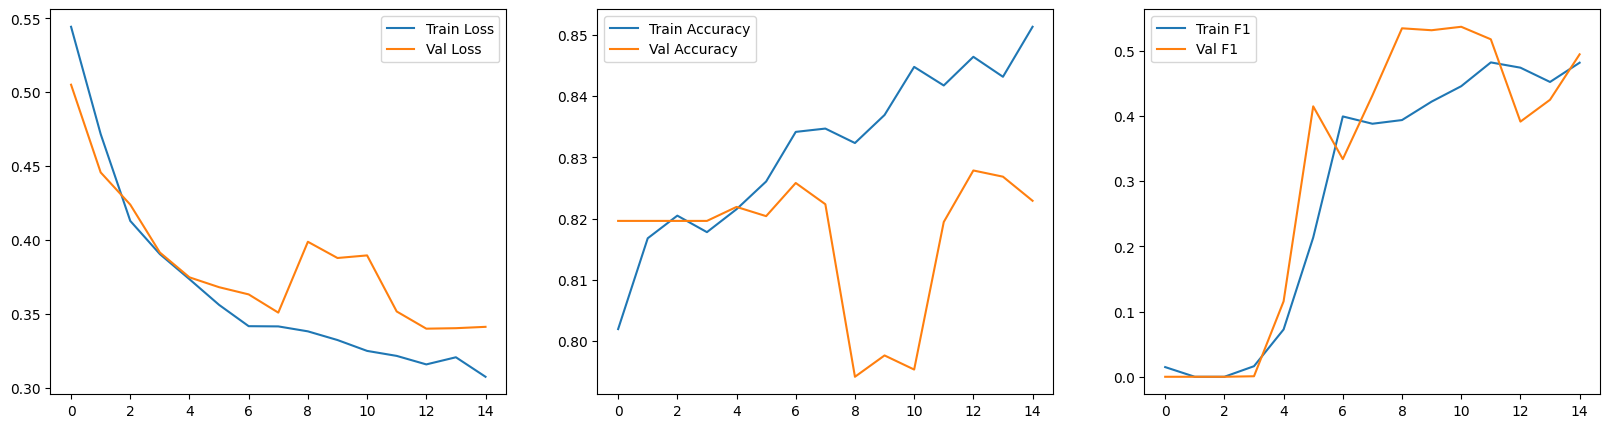

In [14]:
plotter(train_loss, val_loss, train_acc, val_acc, train_f1, val_f1)